In [1]:
import os
import tensorflow as tf
import numpy as np
import visualize

# eager execution
#tf.enable_eager_execution()
#tf.executing_eagerly()

# tensorflow config - using one gpu and extending the GPU 
# memory region needed by the TensorFlow process
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

#### load dataset

In [2]:
from detection.datasets import coco, data_generator

In [3]:
img_mean = (123.675, 116.28, 103.53)
# img_std = (58.395, 57.12, 57.375)
img_std = (1., 1., 1.)

In [5]:
train_dataset = coco.CocoDataSet('/Users/nikki/Documents/coco2017', 'train',
                                 flip_ratio=0.5,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(800, 1216))

train_generator = data_generator.DataGenerator(train_dataset)


loading annotations into memory...
Done (t=12.28s)
creating index...
index created!


In [16]:
print(train_dataset[0][2].shape)

(30, 4)


#### display a sample

In [5]:
from detection.datasets.utils import get_original_image
img, img_meta, bboxes, labels = train_dataset[0]

rgb_img = np.round(img + img_mean)
ori_img = get_original_image(img, img_meta, img_mean)

visualize.display_instances(rgb_img, bboxes, labels, train_dataset.get_categories())

AttributeError: 'NoneType' object has no attribute 'shape'

#### load model

In [6]:
from detection.models.detectors import faster_rcnn

model = faster_rcnn.FasterRCNN(
    num_classes=len(train_dataset.get_categories()))

In [7]:
batch_imgs = tf.Variable(np.expand_dims(img, 0))
batch_metas = tf.Variable(np.expand_dims(img_meta, 0))

_ = model((batch_imgs, batch_metas), training=False)

In [8]:
model.load_weights('weights/faster_rcnn.h5', by_name=True)

In [9]:
proposals = model.simple_test_rpn(img, img_meta)
res = model.simple_test_bboxes(img, img_meta, proposals) 

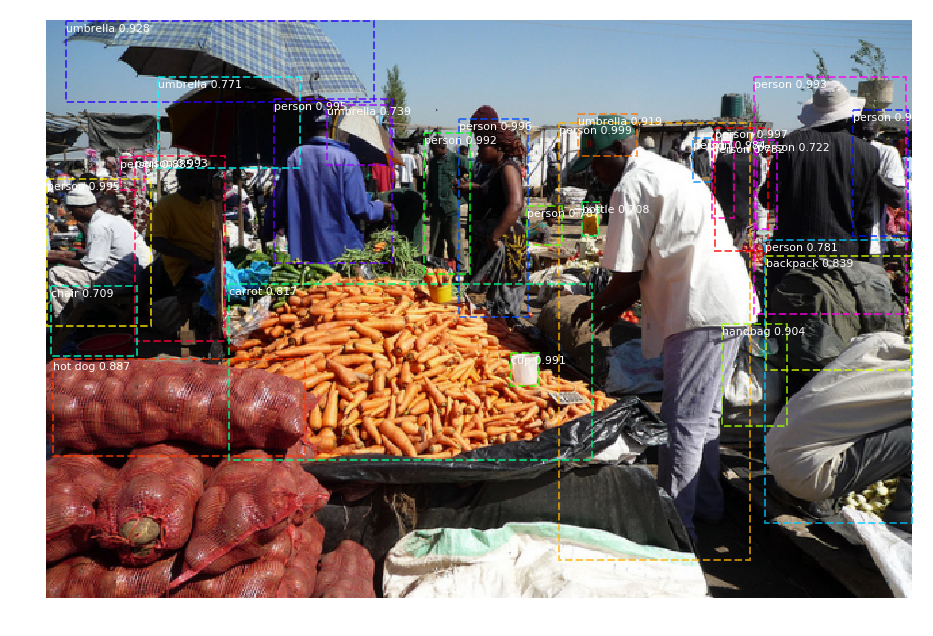

In [10]:
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### use tf.data

In [11]:
batch_size = 1

train_tf_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.float32, tf.float32, tf.float32, tf.int32))
train_tf_dataset = train_tf_dataset.padded_batch(
    batch_size, padded_shapes=([None, None, None], [None], [None, None], [None]))

#### overfit a sample

In [12]:
optimizer = tf.train.MomentumOptimizer(1e-3, 0.9, use_nesterov=True)

epochs = 100

for epoch in range(epochs):
    iterator = train_tf_dataset.make_one_shot_iterator()

    loss_history = []
    for (batch, inputs) in enumerate(iterator):
    
        batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
        with tf.GradientTape() as tape:
            rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
                model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

            loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        loss_history.append(loss_value.numpy())
        break

    print('epoch', epoch, '-', np.mean(loss_history))

epoch 0 - 1.5459183
epoch 1 - 1.3452026
epoch 2 - 1.3130083
epoch 3 - 1.4726529
epoch 4 - 1.3145761
epoch 5 - 0.97886115
epoch 6 - 0.9072726
epoch 7 - 0.9611243
epoch 8 - 0.8133636
epoch 9 - 0.71981156
epoch 10 - 0.66331017
epoch 11 - 0.6967776
epoch 12 - 0.8233839
epoch 13 - 0.5853209
epoch 14 - 0.7458478
epoch 15 - 0.49090627
epoch 16 - 0.70155483
epoch 17 - 0.52923477
epoch 18 - 0.54981387
epoch 19 - 0.47840756
epoch 20 - 0.44117814
epoch 21 - 0.4100888
epoch 22 - 0.3664115
epoch 23 - 0.5025314
epoch 24 - 0.46392125
epoch 25 - 0.42176348
epoch 26 - 0.337227
epoch 27 - 0.24062617
epoch 28 - 0.38677725
epoch 29 - 0.28819728
epoch 30 - 0.31056172
epoch 31 - 0.24173987
epoch 32 - 0.2495406
epoch 33 - 0.28489316
epoch 34 - 0.27561057
epoch 35 - 0.1974902
epoch 36 - 0.23594943
epoch 37 - 0.27512103
epoch 38 - 0.23081067
epoch 39 - 0.21172339
epoch 40 - 0.20311995
epoch 41 - 0.23359463
epoch 42 - 0.29895556
epoch 43 - 0.28704458
epoch 44 - 0.19945247
epoch 45 - 0.15957971
epoch 46 - 0.1841

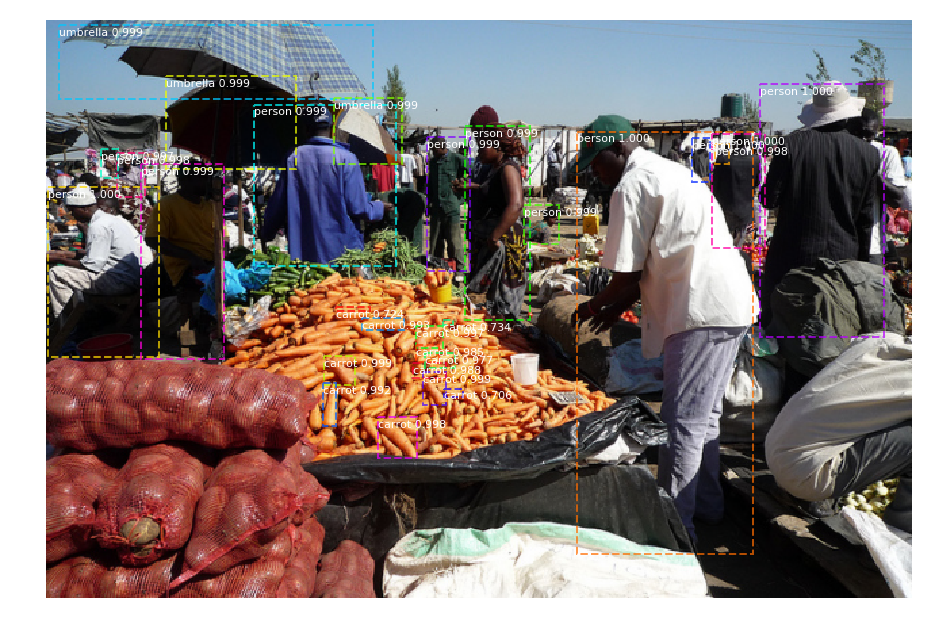

In [13]:
proposals = model.simple_test_rpn(img, img_meta)
res = model.simple_test_bboxes(img, img_meta, proposals)
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### train model

In [14]:
optimizer = tf.train.MomentumOptimizer(1e-3, 0.9, use_nesterov=True)

epochs = 20

for epoch in range(epochs):
    iterator = train_tf_dataset.make_one_shot_iterator()

    loss_history = []
    for (batch, inputs) in enumerate(iterator):
    
        batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
        with tf.GradientTape() as tape:
            rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
                model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

            loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        loss_history.append(loss_value.numpy())

    print('epoch', epoch, '-', np.mean(loss_history))